# Bicycle classification - Pipeline, RandomzidedSearch, CrossValidation

## 1. Import and split

In [70]:
import pandas as pd
from Functions import BIKED_classif_functions as BIKED
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier     #Depth-8 Decision Tree
from sklearn.neighbors import KNeighborsClassifier  #K-Neighbors
from sklearn.ensemble import RandomForestClassifier #Random Forest


from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config


For other Classification models see here:

In [71]:
#more models used by the author:

from sklearn.ensemble import AdaBoostClassifier        #AdaBoost
from sklearn.svm import SVC                            #Support Vector Clf.

from sklearn.gaussian_process import GaussianProcessClassifier     #Gaussian Pr. Clf.
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.neural_network import MLPClassifier                   #3-layer Neural Net, #6-Layer Neural Net
                                                                    

#other models:
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### 1.1. Training data

In [76]:
#Read Data
data = pd.read_csv("Data/BIKED_reduced.csv", index_col=0)



## here I use the processed dataset
processed = pd.read_csv("Data/BIKED_processed.csv", index_col=0)
#processed["BIKESTYLE"] = data["BIKESTYLE"]
#print(processed.shape, data.shape)
#data = processed


In [ ]:

#data_columns = data.dtypes
data = data.loc[(data["BIKESTYLE"] == "ROAD") | (data["BIKESTYLE"] == "TRACK"), :]



In [176]:
#part of analysis 
data.SSSIDECX3.value_counts()
data.SSSIDECX3.isna().value_counts()

False    4512
Name: SSSIDECX3, dtype: int64

In [73]:

classes = data["BIKESTYLE"].value_counts() # 19 categories, one of them has only one member
classes = pd.DataFrame(classes)
classes.columns = ["bikestyle_count"]
classes["percentage"] = (classes.bikestyle_count / data.shape[0] * 100).round(2)
classes


,bikestyle_count,percentage
ROAD,1856,41.13
MTB,616,13.65
TRACK,470,10.42
OTHER,315,6.98
DIRT_JUMP,293,6.49
TOURING,201,4.45
CYCLOCROSS,151,3.35
POLO,128,2.84
TIMETRIAL,89,1.97
BMX,86,1.91


In [23]:
data.shape

(2326, 1320)

* label `BIKESTYLE` has 19 categories
* class `FAT`has only one row
* class `CRUISER`, `HYBRID`, `TRIALS`, `GRAVEL`, `CARGO`, `CHILDRENS`, and `FAT` are extremly unbalanced with < 1% of total rows
* If all classes would be evenly distributed, each of them had 5 %

In [74]:
#call function to drop <0.1% of values
data = BIKED.remove_classes_with_less_than_x_percent(data)
data.BIKESTYLE.value_counts()


ROAD          1856
MTB            616
TRACK          470
OTHER          315
DIRT_JUMP      293
TOURING        201
CYCLOCROSS     151
POLO           128
TIMETRIAL       89
BMX             86
COMMUTER        75
CITY            72
CRUISER         42
HYBRID          39
TRIALS          35
GRAVEL          19
CARGO           14
CHILDRENS       10
Name: BIKESTYLE, dtype: int64

In [26]:
data.SIZE.value_counts().head(50)
## break up SIZE in different columns


54        228
56        184
52        145
58        109
53        101
55         86
57         65
M          61
50         52
48         45
51         36
L          36
60         35
61         32
59         28
27         23
Large      19
49         18
26         16
56cm       16
custom     14
Medium     13
54cm       13
62         12
Custom     11
M/L        11
58cm       10
S          10
64          8
XL          8
63          8
47          7
medium      7
small       7
56cm.       7
535         6
53.5        6
s           5
525         5
57.5        5
55cm        5
550         5
m           5
46          4
20          4
56 cm       4
50cm        4
57cm        4
61cm        4
500         4
Name: SIZE, dtype: int64

In [68]:

data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"inch")),:]
# 9 rows which have "inch"


,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,HBAR type,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Rollout units,...,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle DOWNTUBE0 CAGE,rockerPosition,RDERD,FDERD,RDBSD,FDBSD
381,55.3,132.3,308.6,-10.0,10.0,Generic track,0,6,36,0,...,NaN,NaN,NaN,NaN,NaN,NaN,92.0,92.0,52.0,52.0


In [69]:
data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"\'\'")),:]
#26 rows with have ''


,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,HBAR type,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Rollout units,...,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle DOWNTUBE0 CAGE,rockerPosition,RDERD,FDERD,RDBSD,FDBSD
379,55.3,132.3,308.6,-10.0,10.0,Generic track,0,6,36,0,...,NaN,NaN,NaN,NaN,NaN,NaN,92.0,92.0,52.0,52.0


In [ ]:
data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"\"")),:]
#320 rows with "
data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"cm")),:]
#201 rows with cm
data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"mm")),:]
#17 rows with mm

data.loc[(data.SIZE.isna() == True),:]
#2902 ohne Size --> nope something is wrong here

#only text (noch nicht fertig)
#data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"^\D")), "SIZE"].value_counts().head(50)

#only zahl (noch nicht fertig)
#data.loc[(data.SIZE.isna() == False) & (data["SIZE"].str.contains(r"^\d")), "SIZE"].value_counts().head(50)



In [28]:
#Split
y = data.pop("BIKESTYLE")

In [33]:
X = data

#X = processed

In [7]:
# check missing values # HIER KÖNNTE ICH LERNEN WIE ICH ES KÜRZER SCHREIBE
missing_values_col = X.isna().sum()
missing_values_col = pd.DataFrame(missing_values_col)
missing_values_col.columns = ["Missing_values_Count"]

missing_values_col = missing_values_col.loc[missing_values_col["Missing_values_Count"] > 0, :]
print(len(missing_values_col))
missing_values_col



35


,Missing_values_Count
HBAR type,219
Headset type,91
Dropout model,73
Top tube angle textfield,1
Seatpost type,166
Stack,73
SIZE,774
dropoutInsert,680
Cranks type,115
Dim A Inch TextField,2


**Conclusion:**
* There are 35 columns with missing values.
* Column `SIZE` has 774 missing values. Interesting, because `SIZE` results in 555 columns after OneHotEncoding.
* Columns `bottle xxx` have many missing values. Might be useful to put them into fewer columns. i.e. `bottle DOWNTUBE` and `bottle SEATTUBE`

In [34]:
#check data types (which columns are not numeric and what to do with them)
X.info() 

#in processed all columns are numeric

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 1 to 4800
Columns: 1319 entries, SSSIDECX3 to FDBSD
dtypes: bool(150), float64(979), int64(153), object(37)
memory usage: 21.1+ MB


In [9]:
categorical_cols = X.select_dtypes(include="object").columns
print(len(list(categorical_cols)))
categorical_cols

#boolean_cols = X.select_dtypes(include="bool").columns
#print(len(boolean_cols))
#boolean_cols

37


Index(['HBAR type', 'Headset type', 'Rack type', 'DIRECTMOUNTFDTYPE',
       'Dropout model', 'HEADTUBEtype', 'BATTERYmount', 'Seatpost type',
       'FRONTbrake type', 'Stem type', 'Pump size', 'MATERIAL',
       'FRONTdiscB type', 'SIZE', 'StaticDropout', 'RIM_STYLE front',
       'SPROCKETS type', 'PhBlock typeDOWNTUBE', 'GEARBOXtype',
       'dropoutInsert', 'REARdiscB type', 'Cranks type', 'MOUNT_TYPE',
       'Yoke type', 'RIM_STYLE rear', 'Brake lever brand', 'Pedals type',
       'Wheel choice rear', 'REARbrake type', 'CLAMPFDTYPE',
       'Wheel choice front', 'PhBlock typeTOPTUBE', 'DROPOUT STYLE',
       'Fit scheme', 'Fork choice', 'Saddle type', 'BRAZEonFDTYPE'],
      dtype='object')

**Conclusion:** 

* There are 187 non-numeric column. of which 150 columns are boolean.
* There are 37 object columns, which need to be encoded (OneHot or Ordinal).




LIST OF COLUMNS:
OBJECT: 
'HBAR type', 'Headset type', 'Rack type', 'DIRECTMOUNTFDTYPE',
       'Dropout model', 'HEADTUBEtype', 'BATTERYmount', 'Seatpost type',
       'FRONTbrake type', 'Stem type', 'Pump size', 'MATERIAL',
       'FRONTdiscB type', 'SIZE', 'StaticDropout', 'RIM_STYLE front',
       'SPROCKETS type', 'PhBlock typeDOWNTUBE', 'GEARBOXtype',
       'dropoutInsert', 'REARdiscB type', 'Cranks type', 'MOUNT_TYPE',
       'Yoke type', 'RIM_STYLE rear', 'Brake lever brand', 'Pedals type',
       'Wheel choice rear', 'REARbrake type', 'CLAMPFDTYPE',
       'Wheel choice front', 'PhBlock typeTOPTUBE', 'DROPOUT STYLE',
       'Fit scheme', 'Fork choice', 'Saddle type', 'BRAZEonFDTYPE'

BOOL: (just a few)
'REARDiscAdaptOnPost', 'Seatpost AERO', 'DOWNTUBE1SnSCheck',
       'USEgearbox', 'REARROTOR_INCLUDE', 'nSeat stay Curv Check',
       'CSSIDEISBENT', 'LINKpump2SCHEME', 'SEATSTAYholeCheck', 'LOOPED_STAYS',
       ...
       'Female', 'Seatpost MAST', 'CASS_aux', 'DUAL_CROWN',
       'REARDiscTabIsPost', 'CHEVRONDOWNTUBE1ON', 'CHEVRONTOPTUBE1ON',
       'Dim A CheckBox', 'bottle SEATTUBE0 show', 'bottle DOWNTUBE0 show'

In [1]:
# which columns have missing values and also have categorical? - yes there are some. 
# Make sure in the preprocessor that they are properly taken care of.
# # # # # #  I wonder how the author took care of it.

categorical_cols.loc[:, categorical_cols.isin(missing_values_col.index)]
#boolean_cols.isin(missing_values_col.index)

NameError: name 'categorical_cols' is not defined

In [11]:
X.shape

(4511, 1318)

In [12]:
# This time take only numerical columns
X = X.select_dtypes(include="number").copy()
X.shape

(4511, 1131)

In [35]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

## 2. Building `preprocessor` pipeline

In [14]:
X_train.head(2)

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Rollout units,Down tube front diameter,...,bottle DOWNTUBE0 WBL,bottle DOWNTUBE0 WBD,bottle SEATTUBE0 CAGE,bottle DOWNTUBE0 flip,bottle DOWNTUBE0 X,bottle DOWNTUBE0 CAGE,rockerPosition,RDERD,FDERD,RDBSD
1845,65.5,130.4,304.2,-10.0,10.0,0,6,39,0,38.1,...,201.0,73.5,1.0,0.0,200.0,1.0,50.0,92.0,92.0,52.0
3510,71.8,134.9,350.0,-10.0,10.0,0,6,36,0,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,92.0,52.0


In [36]:
# 2.a) Select categorical and numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()


In [37]:

# 2.b) Numerical Pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(
#    MinMaxScaler(),
    SimpleImputer(strategy="constant")   #strategy="constant"
    #KNNImputer(5)
)


In [ ]:

# 2.d) Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
    ]
)

In [39]:
X_train.shape

(1860, 1319)

# 3. Evaluating Models

In [40]:
from sklearn.ensemble import AdaBoostClassifier        #AdaBoost
from sklearn.svm import SVC                            #Support Vector Clf.

from sklearn.gaussian_process import GaussianProcessClassifier     #Gaussian Pr. Clf.
from sklearn.neural_network import MLPClassifier                   #3-layer Neural Net, #6-Layer Neural Net
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

def get_model_and_params(model_name, param_grid):
    if model_name == "rforest":
        model = RandomForestClassifier()
        param_grid.update({"randomforestclassifier__warm_start": [True, False],
                "randomforestclassifier__n_estimators": [100, 200],
                "randomforestclassifier__max_depth": range(2, 14),
                "randomforestclassifier__min_samples_leaf": range(2, 10),
                "randomforestclassifier__criterion":["gini", "entropy"]})
    elif model_name == "knn":
        model = KNeighborsClassifier()
        param_grid.update({"kneighborsclassifier__n_neighbors": range(2, 50),
                "kneighborsclassifier__weights": ["uniform", "distance"]})
    elif model_name == "dt":
        model = DecisionTreeClassifier()
        param_grid.update({"decisiontreeclassifier__max_depth": range(2, 14),
                "decisiontreeclassifier__min_samples_leaf": range(2, 12),
#               "decisiontreeclassifier__min_samples_split": range(3, 40, 2),
                "decisiontreeclassifier__criterion":["gini", "entropy"]})
    elif model_name == "Ada":
        model = AdaBoostClassifier()
        param_grid.update({#"adaboostclassifiert__estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
                "adaboostclassifier__n_estimators": [50, 80],
                "adaboostclassifier__learning_rate": [0.5, 1.0, 1.5, 2.0, 2.5]})
    #elif model_name == "SVC": # runtime too long. Stopped after 2 hours 
    #    model = SVC()
    #    param_grid.update({"svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    #            "svc__class_weight": ["balanced", "None"]})
    elif model_name == "GaussPrC":
        model = GaussianProcessClassifier(1.0 * RBF(1.0))
        param_grid.update({"gaussianprocessclassifier__multi_class": ["one_vs_rest", "one_vs_one"]})
    elif model_name == "mlp":
        model = MLPClassifier()
        param_grid.update({"mlpclassifier__hidden_layer_sizes": [(200), (200, 200)],
            "mlpclassifier__max_iter": [3000, 5000]})

    return model, param_grid




In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

def evaluate_model(list_of_models, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": []
    }
    param_grid = {}
    
    for i in list_of_models:
        #reset values to be empty : 
        model = ""
        param_grid.clear()
        param_grid = param_grid_preproc

        # # # # it would nice if I make this into a function get_model_and_params
        model, param_grid = get_model_and_params(i, param_grid)

        #create the full_pipeline
        full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

        # define cross validation
        search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=5,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5
                    )                             

        # fit
        search.fit(X_train, y_train)
        print(search.best_params_)

        score_new["model"].append(i)

        ### testing accuracy
        y_test_pred = search.predict(X_test)
        acc_test = accuracy_score(y_test, y_test_pred)
        score_new["test_acc_score"].append(acc_test)

        #get score of TRAIN-Data (overfitting?)
        y_train_pred = search.predict(X_train)
        acc_train = accuracy_score(y_train, y_train_pred)
        score_new["train_acc_score"].append(acc_train)

        # keep scores of model (optional)
        score_new["best_score_of_CV"].append(search.best_score_)
        score_new["best_params"].append(search.best_params_)

        # confusion matrix
        conf = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                    display_labels=search.classes_)
        disp.plot()
        plt.show()
        #import seaborn --> I couldn't find how to print a table with seaborn

        #how do I use set_palette()
        #change plt.show() to sns.show()
        #How to set the palette to have the colors of my presentation?

        print(i, model)
        print(pd.DataFrame(conf))
        print("end")
    return pd.DataFrame(score_new)



In [2]:
## Create the correlation matrix, using the absolute values.
## For our purpose, it doesn't matter whether the correlation is positive or negative.

#corrMatrix = X_train.corr().abs()

## Plot a heatmap of the correlation matrix.
#fig, ax = plt.subplots(figsize=(18,18))
#sns.heatmap(corrMatrix, annot=True);

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'randomforestclassifier__warm_start': True, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'entropy'}


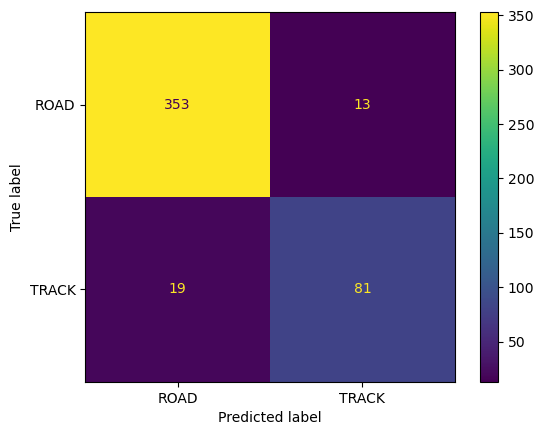

rforest RandomForestClassifier()
     0   1
0  353  13
1   19  81
end


In [66]:
# set models, pass param_grid for preprocessor-pipeline
list_of_models = ["rforest"] # , , "knn", "dt", "mlp", "rforest", "knn", "dt", "GaussPrC", "mlp" "SVC" "Ada", , "mlp"

param_grid_preproc = {}

score_new = evaluate_model(list_of_models, param_grid_preproc)


# Keep track of scores

In [52]:
#Set to Initialize = True when you want to start over.
initialize_all_scores = True    

if initialize_all_scores == True:
    score_all = {
        "model": [], 
        "test_acc_score" : [],
        "train_acc_score" : [],
        "best_params": [],
        "best_score_of_CV": [],
        "dataset": [],
        "preprocessing": [],
    }
    score_all = pd.DataFrame(score_all)

In [50]:
score_new
# the ada boost - which is not a model itself but a way to stack things together performs really bad. Ada-Boost 
# 

,model,test_acc_score,train_acc_score,best_score_of_CV,best_params
0,rforest,0.924893,0.958602,0.930645,"{'randomforestclassifier__warm_start': False, ..."


In [53]:
#description of the current round
#score_all = pd.DataFrame([]) --> only once!
dataset = "reduced,ROADvsTRACK" #"reduced,18labels"   #"reduced,19labels"
preprocessing = "only_numeric,SimpleImputer,StandardScaler" #"only_numeric_cols,SimpleImputer_Mean"  #"all_columns,SimpleImputer_Mean,OneHot"

score_new["dataset"] = dataset
score_new["preprocessing"] = preprocessing


In [54]:

score_all = pd.concat([score_all, score_new], ignore_index=True)

In [55]:
score_all

,model,test_acc_score,train_acc_score,best_params,best_score_of_CV,dataset,preprocessing
0,rforest,0.924893,0.958602,"{'randomforestclassifier__warm_start': False, ...",0.930645,"reduced,ROADvsTRACK","only_numeric,SimpleImputer,StandardScaler"


In [48]:
#store results
pd.DataFrame(score_all).to_csv("all_scores_2.csv")




NameError: name 'score_all' is not defined